In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We'll be doing a classic survival analysis model, using Cox PH to look at sex differences in time to death (aka. longevity) using data from the [U.S.  National Health Interview Survey](https://ihis.ipums.org/).  This data is particularly great because they have both year of birth and year of death.  Death records stop in 2009 (when the dataset was considered complete), so any people who are still living in 2009 will need to be right-censored.

Some people do not have date of birth.  Those cases will be truncated.  

Let's start by [loading the data](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/nhis.csv), taking a look at it, and cleaning it up:

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("assets/nhis.csv")
print(data.head())
print(data.shape)


   Unnamed: 0  YEAR           NHISPID  AGE  SEX  SEXORIEN  MARSTAT  BIRTHYR  \
0     2744230  1986  1986109602890101   60    1       NaN       11      NaN   
1     2744231  1986  1986109602890102   54    2       NaN       11      NaN   
2     2744232  1986  1986109602890103   21    1       NaN       50      NaN   
3     2744233  1986  1986109602890201   46    1       NaN       11      NaN   
4     2744234  1986  1986109602890202   38    2       NaN       11      NaN   

   MORTSTAT  MORTDODY  
0       1.0    2005.0  
1       1.0    2010.0  
2       2.0    9999.0  
3       2.0    9999.0  
4       2.0    9999.0  
(1605246, 10)


C:\Users\Bethany\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bethany\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bethany\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  female  
829402   1963.0       2.0    9999.0       46.0   0.0       1  
829403   1960.0       2.0    9999.0       49.0   0.0       0  
829404   1954.0       1.0    1999.0       45.0   1.0       0  
829405   1944.0       2.0    9999.0       65.0   0.0       1  
829407   1955.0       2.0    9999.0       54.0   0.0       0  
(754219, 13)


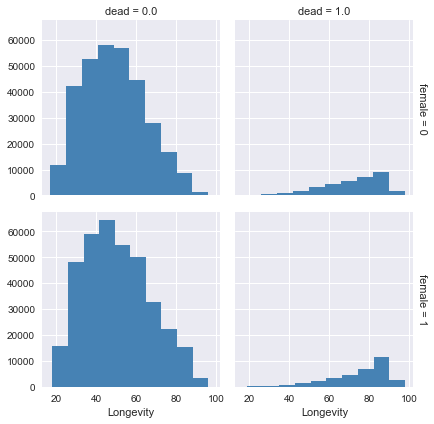

In [82]:

# Dropping cases where birth year is not known
data2 =data[(data["BIRTHYR"]<=2009) & (data["BIRTHYR"].notnull())]

# Calculating time-to-event
data2["Longevity"]= data2["MORTDODY"] - data2["BIRTHYR"]

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"]=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead']==0,"Longevity"] = 2009 -data2.loc[data2['dead']==0,"BIRTHYR"] 

# Creating a binary variable where 1 = female and 0 = male
data2["female"] = (data2["SEX"] == 2).astype(int)

print(data2.head())
print(data2.shape)

g = sns.FacetGrid(data2, row="female", col="dead",margin_titles=True)
g.map(plt.hist, "Longevity", color="steelblue", lw=0)
plt.show()

# The first look

After data cleaning, we've gone from 1605246 records to 1305561.  The vast majority of our sample was still living as of 2009.  This means most of our data will be right-censored.

Now we're going to use the `statsmodels` survival analysis functions to create some models for our data.  First, we can calculate the Hazard (risk of death) for each age, starting at the youngest people in the sample (18 years old in 2009). 

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sf = sm.SurvfuncRight(data2["Longevity"], data2["dead"])
sf.summary().head()

C:\Users\Bethany\Anaconda3\lib\site-packages\statsmodels\duration\survfunc.py:48: RuntimeWarning: invalid value encountered in greater
  ii = np.flatnonzero(d > 0)


,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999998,0.000001,1305559,2.0
19.0,0.999989,0.000003,1304781,12.0
20.0,0.999965,0.000005,1303253,31.0
21.0,0.999930,0.000007,1300756,46.0
22.0,0.999899,0.000009,1297511,40.0


You can notice a few things in the survival table: 
* First, only 2 people in the sample died at the age of 18, with the number of deaths increasing after that.
* Second, the standard error steadily gets larger as the sample size (the number at risk, aka. the number of people alive at that timepoint) shrinks.  
* Finally, the 'number at risk' drops at each timepoint, but by quite a bit more than the number of deaths.  This reflects our right-censoring.  If someone turned 18 in 2009 and didn't die, they don't count toward the 'number at risk' at age 19 because they're out of the observation window, but they also aren't an event at timepoint 18 because they were still alive at that age.

We can also make a very nice survival plot for the men and the women:

C:\Users\Bethany\Anaconda3\lib\site-packages\statsmodels\duration\survfunc.py:48: RuntimeWarning: invalid value encountered in greater
  ii = np.flatnonzero(d > 0)


(0.85, 1)

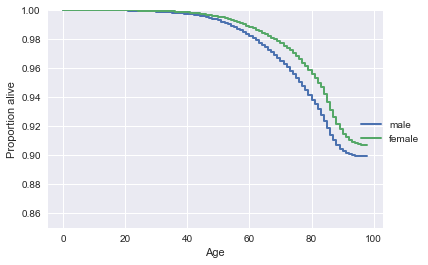

In [25]:
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby("female")
ax = plt.axes()
sexes = ["male","female"]
# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])



Most people are still alive, but this may be due to extreme right-censoring.  

# Cox PH for gender

A graph is all very well, but is the difference in longevity for men and women meaningful?  We can test using the Cox PH model.

In [27]:
mod = smf.phreg("Longevity ~  female", # The model
                data2, # The data
                status=data2['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
print(rslt.summary())

                       Results: PHReg
Model:                  PH Reg        Sample size:     754217
Dependent variable:     Longevity     Num. events:     67383 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4460    0.0078 0.6402 -57.5296 0.0000 0.6306 0.6500
Confidence intervals are for the hazard ratios


It looks like the difference is meaningful.  The convention is to report and interpret the Hazard Ratio (HR) rather than the log HR.  According to the Cox PH, at any given age, women are 64% less likely to die than men, with a 95% confidence interval of 63% to 65%.  This difference is statistically significant at $\alpha$ of .05 (p < .0001).  Our confidence interval is tiny because our sample is so big!

Looking from the plot to the model, you may notice that the data tell a slightly different story.  The survival rate discrepancy seems to shrink a bit after age 80.  This suggests that either we should include some additional features in the model to try and account for this discrepancy, or we should use a different modeling technique that doesn't assume that the effects of features are consistent across all values.

We can plot the predicted survival rates from the model:

C:\Users\Bethany\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


         YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  BIRTHYR  MORTSTAT  \
3928174  1997  19970003080101   33    2       NaN       11   1963.0       2.0   
3928175  1997  19970003080102   36    1       NaN       11   1960.0       2.0   
3928178  1997  19970003090101   42    1       NaN       11   1954.0       1.0   
3928179  1997  19970003090102   52    2       NaN       11   1944.0       2.0   
3928182  1997  19970003100101   41    1       NaN       11   1955.0       2.0   

         MORTDODY  Longevity  dead  female  predicted  
3928174    9999.0       46.0   0.0       1   0.994803  
3928175    9999.0       49.0   0.0       0   0.988401  
3928178    1999.0       45.0   1.0       0   0.992777  
3928179    9999.0       65.0   0.0       1   0.956459  
3928182    9999.0       54.0   0.0       0   0.978739  


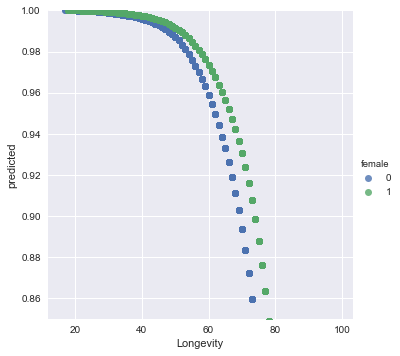

In [59]:
data3=data2[(data2['Longevity'].notnull()) & (data2['female'].notnull()) & (data2['dead'].notnull())]
data3["predicted"] = rslt.predict(pred_type='surv').predicted_values

print(data3.head())

sns.lmplot(x="Longevity", y="predicted", hue="female", data=data3,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()


Going back to the survival rates from the raw data, it does appear this model is missing some elements, including the shrinkage in the gender difference after 80, but also the leveling-off of the survival rate once people get to 90 years or older.  Again, adding more parameters may help.

# Drill

They say that people who get married live longer than people who don't.  Test that assertion by using marital status as an additional feature in your model.  You'll need to create a feature that differentiates the never married from everyone else- check [the codebook](https://nhis.ipums.org/nhis-action/variables/MARSTAT#codes_section) to get started.  Does marriage make a difference?  Calculate the survival plot and the hazard ratio for being married at any point a lifetime.

